# 特别针对模态I腔室4归一化后的预测
模态I：腔室4、5、6，阶段A、MRR范围[50,90]、批次个数（训练集798、验证集185、测试集165）
提取统计特征：平均值
模型：（1）线性模型：LinearRegression/Lasso/Ridge/Elastic/BayesianRidge（2）KNN（3）SupportVector（4）树模型DecisionTree（5）集成树模型：RandomForest/ExtraTree（6）集成模型：AdaBoost/GBDT（GradientBoostingDecisionTree）/Xgboost/LightGBM

In [133]:
#导入库
# This makes it so that matplotlib graphics will show up within the Jupyter Notebook.
%matplotlib inline

# Standard library import

# Data Analysis Tools
import pandas as pd
import numpy as np

# Visualization Tools
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning Tools
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, ExtraTreesRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
# File Loading Tools 
import os

**<font color=grey>1 加载数据，提取统计特征</font>**

In [3]:
# 读入归一化后的数据，线性模型需要数据归一化，树模型不需要数据归一化，那么统一将数据归一化对树模型的预测结果影响不大
Train_data = pd.read_csv('./data phm 2016/Train_data_modeI_chamber4_mm.csv')
Test_data = pd.read_csv('./data phm 2016/Test_data_modeI_chamber4_mm.csv')
print(Train_data.shape, Test_data.shape)
                         

(147701, 27) (30600, 27)


In [11]:
cols_all = list(Train_data.columns)
cols_feature = ['USAGE_OF_BACKING_FILM', 'USAGE_OF_DRESSER',
       'USAGE_OF_POLISHING_TABLE', 'USAGE_OF_DRESSER_TABLE',
       'PRESSURIZED_CHAMBER_PRESSURE', 'MAIN_OUTER_AIR_BAG_PRESSURE',
       'CENTER_AIR_BAG_PRESSURE', 'RETAINER_RING_PRESSURE',
       'RIPPLE_AIR_BAG_PRESSURE', 'USAGE_OF_MEMBRANE',
       'USAGE_OF_PRESSURIZED_SHEET', 'SLURRY_FLOW_LINE_A',
       'SLURRY_FLOW_LINE_B', 'SLURRY_FLOW_LINE_C', 'WAFER_ROTATION',
       'STAGE_ROTATION', 'HEAD_ROTATION', 'DRESSING_WATER_STATUS',
       'EDGE_AIR_BAG_PRESSURE']
col_y = ['AVG_REMOVAL_RATE']
cols_unit = ['Unnamed: 0', 'MACHINE_ID', 'MACHINE_DATA', 'TIMESTAMP', 'STAGE', 'CHAMBER']
cols_data = list(set(cols_all) - set(cols_unit)) # 提取数据用的cols
print('number of variable: ', len(cols_feature))
print('number of data: ', len(cols_data))

number of variable:  19
number of data:  21


In [79]:
# 提取统计特征：平均值
datagroup_train = Train_data.loc[:, cols_data].groupby(['WAFER_ID'], sort = False).agg(np.mean)
datagroup_test = Test_data.loc[:, cols_data].groupby(['WAFER_ID'], sort = False).agg(np.mean)

In [80]:
# 按照WAFER_ID递增顺序排序
datagroup_train.sort_index(inplace=True)
datagroup_test.sort_index(inplace=True)

In [81]:
# 切分训练集
train_x = datagroup_train.loc[:, cols_feature] #训练集样本
train_y = datagroup_train.loc[:, col_y]  #训练集标签 

# 切分测试集
test_x = datagroup_test.loc[:, cols_feature] #测试集样本
test_y = datagroup_test.loc[:, col_y]  #测试集标签

print('训练集样本大小: ', train_x.shape, train_y.shape)
print('测试集样本大小', test_x.shape, test_y.shape)

训练集样本大小:  (798, 19) (798, 1)
测试集样本大小 (165, 19) (165, 1)


慎重执行保存code

In [83]:
# # # 保存数据
# train_x.to_csv("./data phm 2016/train_x_mean_modeI_chamber4_mm.csv", index=True)
# train_y.to_csv("./data phm 2016/train_y_mean_modeI_chamber4_mm.csv", index=True)

# test_x.to_csv("./data phm 2016/test_x_mean_modeI_chamber4_mm.csv", index=True)
# test_y.to_csv("./data phm 2016/test_y_mean_modeI_chamber4_mm.csv", index=True)

In [85]:
# 读取时的用法
train_x = pd.read_csv("./data phm 2016/train_x_mean_modeI_chamber4_mm.csv").set_index('WAFER_ID')
train_y = pd.read_csv("./data phm 2016/train_y_mean_modeI_chamber4_mm.csv").set_index('WAFER_ID')

test_x = pd.read_csv("./data phm 2016/test_x_mean_modeI_chamber4_mm.csv").set_index('WAFER_ID')
test_y = pd.read_csv("./data phm 2016/test_y_mean_modeI_chamber4_mm.csv").set_index('WAFER_ID')

## 2 封装训练和预测的函数

In [61]:
def model_fit_predict(model, train_x, train_y, test_x, test_y):
    model.fit(train_x, train_y)
    expected = test_y
    predicted = model.predict(test_x)
    
    return model, expected, predicted

In [62]:
def plot_curve(expected, predicted):
    # 绘制预测值图像和实值图像
    plt.figure(figsize=(15,3))
    plt.plot(np.arange(len(expected)),expected,color='blue',linewidth=1.0,linestyle='-',label='true value')
    plt.plot(np.arange(len(predicted)),predicted,color='red',linewidth=1.0,linestyle='-',label='predict value')
    plt.title('prediction curve')
    plt.legend(loc='upper right') 
    plt.show()
    
    print('MSE: ', mean_squared_error(expected, predicted))  # 均方误差，越小越好
    print('RMSE: ', np.sqrt(mean_squared_error(expected, predicted)))  # 根均方误差，越小越好
    print('MAE: ', mean_absolute_error(expected, predicted))  # 平均绝对误差，越小越好
    print('R^2: ', r2_score(expected, predicted))  # r2 score 满分1，越接近1越好

### 3 回归模型
（1）线性模型：LinearRegression/Lasso/Ridge/Elastic/BayesianRidge（2）KNN（3）SupportVector（4）树模型DecisionTree（4）集成树模型：RandomForest/ExtraTree（5）集成模型：AdaBoost/GBDT（GradientBoostingDecisionTree）/Xgboost/LightGBM

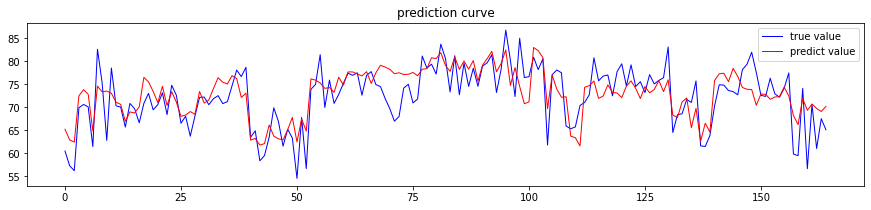

MSE:  18.40326734037618
RMSE:  4.2899029523260985
MAE:  3.382545937817018
R^2:  0.5535751917187594


In [93]:
# Linear Regression
model_lr = LinearRegression()
model_lr, expected, predicted = model_fit_predict(model_lr, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

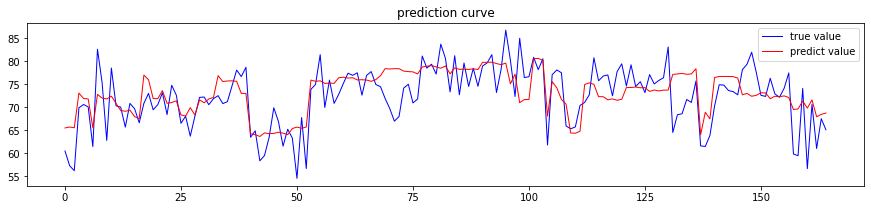

MSE:  23.201992117349246
RMSE:  4.816844622504368
MAE:  3.756318816449938
R^2:  0.4371681565476422


In [91]:
# Lasso
model_lasso = Lasso(alpha=0.025)
model_lasso, expected, predicted = model_fit_predict(model_lasso, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

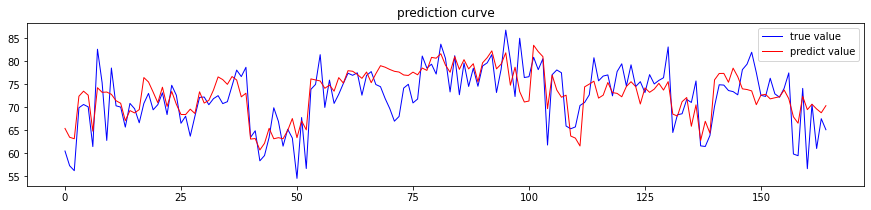

MSE:  18.980160690886873
RMSE:  4.356622624337214
MAE:  3.4136713468881035
R^2:  0.5395809645721794


In [94]:
# Ridge
model_ridge = Ridge(alpha=0.002)
model_ridge, expected, predicted = model_fit_predict(model_ridge, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

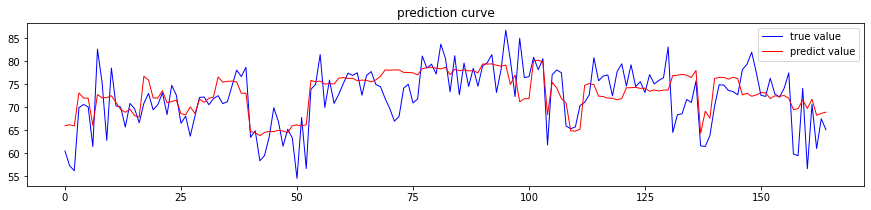

MSE:  22.983336740973012
RMSE:  4.794093943694993
MAE:  3.7346831528146183
R^2:  0.44247227905333775


In [95]:
# ElasticNet
model_elastic = ElasticNet(alpha=0.02, l1_ratio=0.7)
model_elastic, expected, predicted = model_fit_predict(model_elastic, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

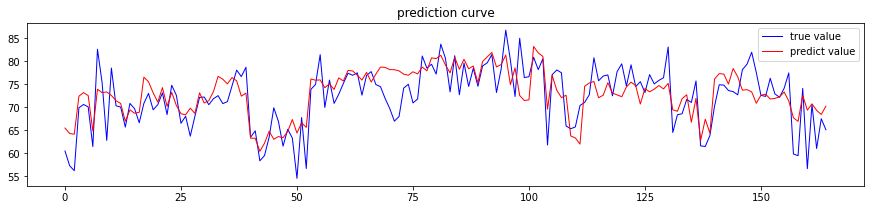

MSE:  19.48656945267956
RMSE:  4.414359461199276
MAE:  3.441667630189882
R^2:  0.5272965462559143


In [123]:
# BayesianRidge
model_baysian_ridge = BayesianRidge(n_iter=300, alpha_1=1e-9, alpha_2=1e-9, lambda_1=1e-9, lambda_2=1e-9, alpha_init=0.2, compute_score=False)
model_baysian_ridge, expected, predicted = model_fit_predict(model_baysian_ridge, train_x, train_y.values.reshape(1,-1)[0], test_x, test_y)
plot_curve(expected, predicted)

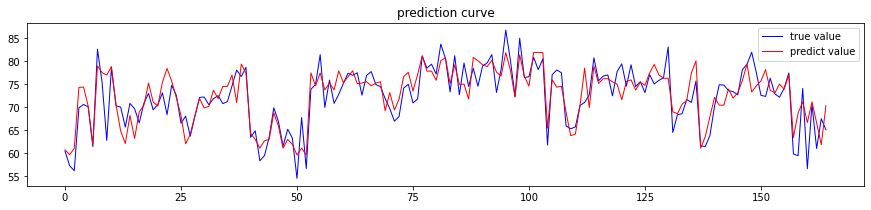

MSE:  12.036216897787723
RMSE:  3.4693251357847283
MAE:  2.592723030303015
R^2:  0.7080265302000184


In [97]:
# KNN
model_knn = KNeighborsRegressor(n_neighbors=3)
model_knn, expected, predicted = model_fit_predict(model_knn, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

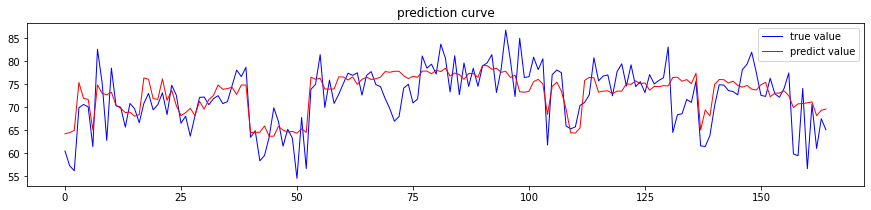

MSE:  20.35427490138359
RMSE:  4.511571223130983
MAE:  3.5521379545528258
R^2:  0.5062478253186046


In [126]:
# Support Vector Regression
model_svc = SVR(kernel='rbf')
model_svc, expected, predicted = model_fit_predict(model_svc, train_x, train_y.values.reshape(1,-1)[0], test_x, test_y)
plot_curve(expected, predicted)

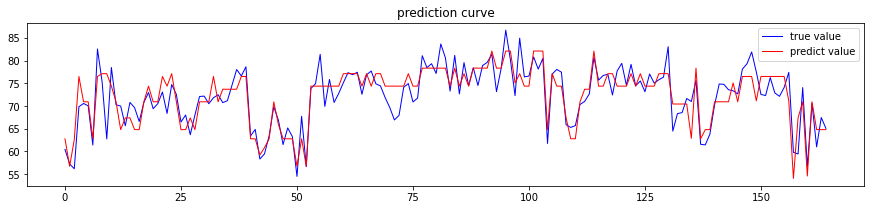

MSE:  10.972580186707187
RMSE:  3.3124885187283573
MAE:  2.5473023006911837
R^2:  0.7338281341240807


In [98]:
# DecisionTree
model_dt = DecisionTreeRegressor(max_depth=5)
model_dt, expected, predicted = model_fit_predict(model_dt, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

/Users/lihan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


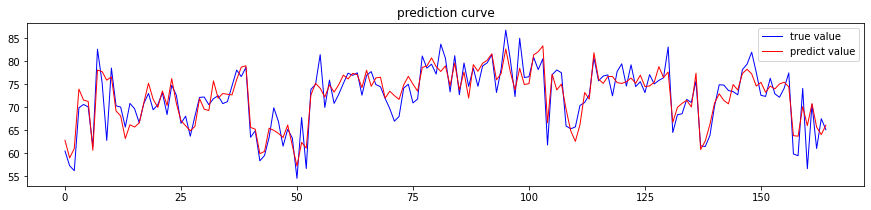

MSE:  8.038112291741156
RMSE:  2.8351564845244708
MAE:  2.2057212454545305
R^2:  0.805012193084281


In [129]:
# RandomForest
model_randomForest = RandomForestRegressor(criterion='squared_error', n_estimators=100, random_state=0)
model_randomForest, expected, predicted = model_fit_predict(model_randomForest, train_x, train_y.values.reshape(1,-1)[0], test_x, test_y)
plot_curve(expected, predicted)

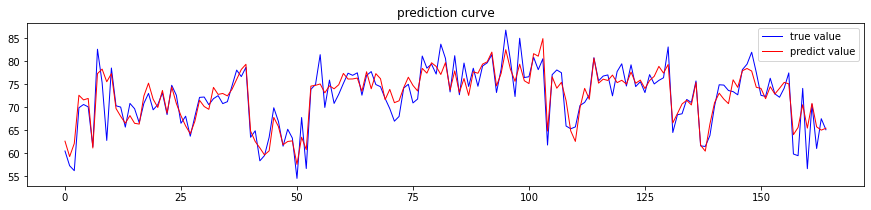

MSE:  7.184692123045649
RMSE:  2.6804276007841827
MAE:  2.0149921636363457
R^2:  0.8257143829806022


In [128]:
# ExtraTree
model_et = ExtraTreesRegressor(n_estimators=50)
model_et, expected, predicted = model_fit_predict(model_et, train_x, train_y.values.reshape(1,-1)[0], test_x, test_y)
plot_curve(expected, predicted)

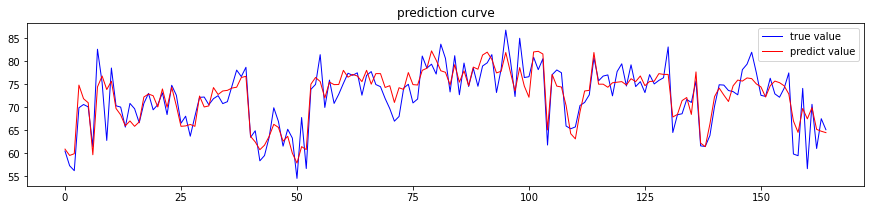

MSE:  9.124732738515908
RMSE:  3.020717255639115
MAE:  2.3674398235547978
R^2:  0.7786530517614999


In [118]:
# AdaBoost
model_ada = AdaBoostRegressor(DecisionTreeRegressor(max_depth=5), n_estimators=100, random_state=None)
model_ada, expected, predicted = model_fit_predict(model_ada, train_x, train_y.values.reshape(1,-1)[0], test_x, test_y)
plot_curve(expected, predicted)

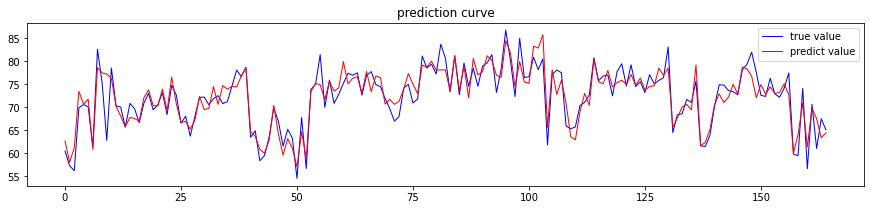

MSE:  7.124812595823879
RMSE:  2.669234458758518
MAE:  1.9806145045650523
R^2:  0.8271669351804662


In [117]:
# GBDT
model_gbdt = GradientBoostingRegressor(n_estimators=50, max_depth=5, learning_rate=0.3)
model_gbdt, expected, predicted = model_fit_predict(model_gbdt, train_x, train_y.values.reshape(1,-1)[0], test_x, test_y)
plot_curve(expected, predicted)

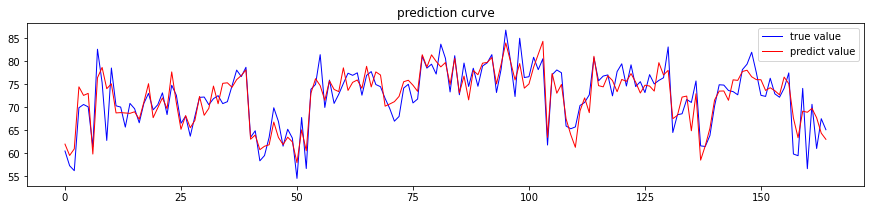

MSE:  8.775932308271573
RMSE:  2.962420008754932
MAE:  2.301947168893508
R^2:  0.7871142213092907


In [131]:
# Xgboost
model_xgb = XGBRegressor(n_estimators=50, max_depth=5, learning_rate=0.3)
model_xgb, expected, predicted = model_fit_predict(model_xgb, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

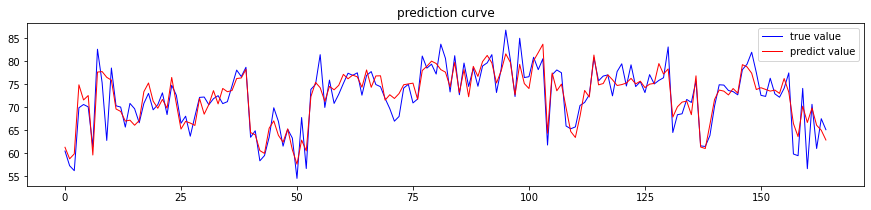

MSE:  7.972876346792967
RMSE:  2.823628223897928
MAE:  2.139380348314662
R^2:  0.8065946807848561


In [132]:
# lightGBM
model_lgbm = LGBMRegressor(n_estimators=100, max_depth=5, num_leaves=10, learning_rate=0.1)
model_lgbm, expected, predicted = model_fit_predict(model_lgbm, train_x, train_y, test_x, test_y)
plot_curve(expected, predicted)

In [137]:
predicted

array([61.26028757, 58.74956966, 59.83162438, 74.835764  , 71.54374747,
       72.50059061, 59.58278733, 77.59993868, 77.71037542, 76.45855872,
       75.85033144, 69.58132795, 69.05288555, 66.95708261, 67.15198547,
       66.05188254, 67.06858899, 73.34580364, 75.23490161, 71.294386  ,
       69.73857   , 71.67128043, 69.75578886, 76.43448259, 70.73963119,
       65.21976285, 66.89433045, 66.52263333, 66.0142418 , 71.87783077,
       68.4527944 , 70.54378047, 73.57344257, 70.6848626 , 74.04578842,
       73.33302325, 73.59911685, 76.19622139, 76.33000513, 78.19486523,
       64.45163039, 63.98095732, 60.54001804, 59.92846445, 65.39759047,
       66.99786823, 63.85196723, 62.37015055, 65.26107618, 60.7268272 ,
       57.58928867, 62.82253604, 60.48163289, 72.26947506, 75.35796879,
       74.20815485, 71.23013759, 74.49721737, 73.74871209, 74.7245285 ,
       77.10494036, 76.14740942, 76.94418394, 76.57084465, 74.3093246 ,
       78.06417435, 74.29156336, 76.76002088, 76.79412718, 71.50

In [138]:
expected

,AVG_REMOVAL_RATE
WAFER_ID,
-4226160404,60.44715
-4224160686,57.25230
-4224160592,56.17860
-4220160654,69.84885
-4141512092,70.56045
...,...
4217773710,56.61465
4221773698,70.59630
4223773496,60.99510


In [154]:
pd.DataFrame(data=enumerate(expected.values.reshape(1,-1)[0]), columns=['Index', 'Value'])

,Index,Value
0,0,60.44715
1,1,57.25230
2,2,56.17860
3,3,69.84885
4,4,70.56045
...,...,...
160,160,56.61465
161,161,70.59630
162,162,60.99510
163,163,67.47135


In [155]:
pd.DataFrame(data=enumerate(predicted), columns=['Index', 'Value'])

,Index,Value
0,0,61.260288
1,1,58.749570
2,2,59.831624
3,3,74.835764
4,4,71.543747
...,...,...
160,160,66.642692
161,161,69.796703
162,162,66.051183
163,163,64.964030
